In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import json

# SSL for emotion analysis
#### 25.11.2020

## Proposal plan

- [x] 1.Setting up the environment
- [x] 2.Corpora preprocessing
- [x] 3.Unlabeled data collecting & cleaning
- [x] 4.Baseline model
- [ ] 5.Semi-supervised Sequence Learning (SSL Model 1) [https://arxiv.org/abs/1511.01432] (Poor performance)

## Labeled Dataset Preparation
- Tokenize by spaCy library and removed NLTK's stopwords
- Made statistics and generate vocabularies for tokens have dominate class trendency. (Threshold at 40%, 60%，80% for top two classes)

For SSEC:
- Removed @usernames and URLs.
- Replaced emojis like :) to special marks and added specail cases to tokenizer.
- Used the labels with highest possible agreement, but without losing labels.

For TEC:
- Cleaned Twitter things just same as in SSEC.
- Removed non-English samples.
- (Optinal) Data augmentation with textaugment library, deal with the unbalance of classes.

For ISEAR:
- Modified special samples in the dataset e.g. \[No response.\]


ISEAR sample:
['When', 'I', 'driving', 'home', 'several', 'days', 'hard', 'work', 'motorist', 'ahead', 'driving', '50', 'km', 'hour', 'refused', 'despite', 'low', 'speeed', 'let', 'overtake'] [3]
ISEAR most frequency tokens:


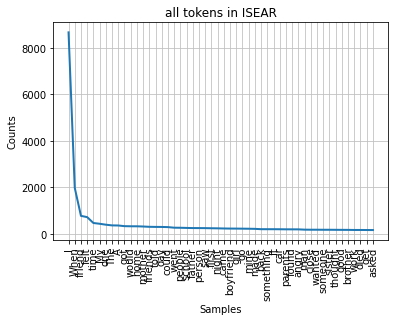

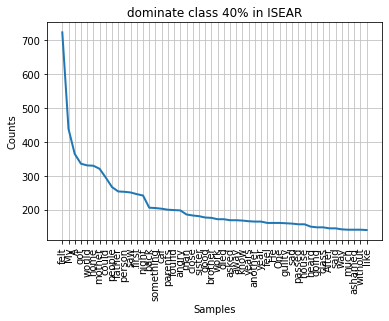

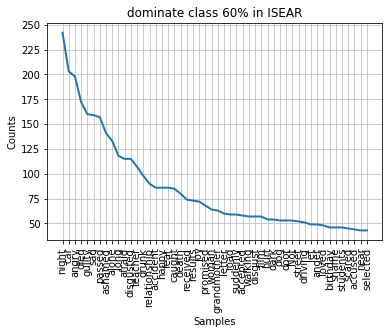

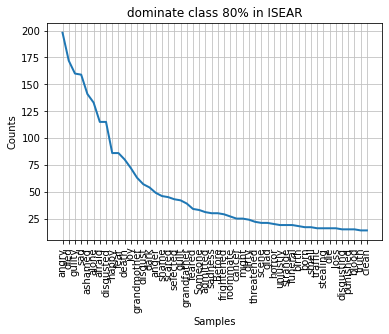

<AxesSubplot:title={'center':'dominate class 80% in ISEAR'}, xlabel='Samples', ylabel='Counts'>

In [1]:
import pre.load_data as load_data
tec_data, isear_data, ssec_data = load_data.load_data()
print('ISEAR sample:')
print(isear_data.get_data()[1], isear_data.get_target()[1])

freq_dist_nltk_0, freq_dist_nltk_40, freq_dist_nltk_60, freq_dist_nltk_80 = load_data.get_freq_plot('isear')
print('ISEAR most frequency tokens:')
freq_dist_nltk_0.plot(50, cumulative=False, title="all tokens in ISEAR")
freq_dist_nltk_40.plot(50, cumulative=False, title="dominate class 40% in ISEAR")
freq_dist_nltk_60.plot(50, cumulative=False, title="dominate class 60% in ISEAR")
freq_dist_nltk_80.plot(50, cumulative=False, title="dominate class 80% in ISEAR")

## Unlabeled Data

### 1.Twitter Data
Take a similar approach to TEC. 
Crawled 10000 tweets that have hashtags with emotions.
Filtered out non-English tweets, about 6000-8000 left for each class.
Then clean them up using the preceding Tokenizer.

Can be used for TEC and SSEC.

### 2.Story Data
Crawled stories form [https://sayitforward.org/stories/].

802 Stories, 34151 sentences. Mostly from women.

Can be used for ISEAR.

### 3.EmoEvent (Not really unlabeled, but used as unlabeled)
From paper:

EmoEvent: A Multilingual Emotion Corpus based on different Events [https://www.aclweb.org/anthology/2020.lrec-1.186/]

The dataset has 7303 English tweets that based on different events and have emotions.

Can be used for SSEC, TEC and ISEAR.


## Baseline Model

In the SSL reference, the model used as a baseline is a simple unidirectional LSTM model using an SGD optimizer with no pre-trained word embedding.

But this didn't work in my experiments because the emotion dataset was difficult to replicate, and a full replication of the model yielded only 16% accuracy in ISEAR and 43% accuracy in TEC, so I added a bidirection model, switched the optimizer to Adam, and used pre-trained word embedding.

After experiments, Fasttext is better than GloVe, got 61% accuracy on ISEAR, 55% accuracy on TEC 73% on SSEC.

Baseline model are LSTM models, consist of:
- Fasttext embedding matrix
- Bidirectional LSTM layer
- 2 Dense layers
- Softmax for ISEAR and TEC, Sigmoid for SSEC


In [4]:
import pre.load_model as load_model

model = load_model.load_model('../results/isear_0_w2v_bi_full/classifier_model.pt').cpu()
print(model)
pred, gold = load_model.evaluate(model, 'isear', True)
from sklearn.metrics import confusion_matrix
confusion_matrix(gold, pred)

RNNModel(
  (drop_em): Dropout(p=0.8, inplace=False)
  (encoder): Embedding(1003101, 300)
  (rnn): LSTM(300, 512, bidirectional=True)
  (dis_out): Sequential(
    (0): Linear(in_features=1024, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=30, out_features=7, bias=True)
  )
)
Accuracy of the classifier on the test data is : 60.9980


array([[148,   7,  11,  14,  11,  10,   9],
       [  7, 145,   9,  12,  14,   8,   8],
       [ 11,   8, 120,  18,  31,  21,  22],
       [ 17,  14,   9, 147,  10,  15,   7],
       [  4,  14,  30,   8, 137,  14,   8],
       [ 11,  16,  19,   5,  25, 125,  22],
       [  6,  14,  24,  20,  17,  34, 107]])

## SSL Model
SSL model consist of a LSTM Language model and a LSTM classifier.

The classifier has the same architecture as the baseline.

The language model has a embedding layer and a LSTM layer, followed by a dense layer as decoder.
The size of embedding matrix and LSTM weight of classifier and LM are same.

We firstly train a LM from unlabeled+labeled dataset, then load the weight into classifier.
Finally train the classifier normally.



In [6]:
import pre.load_model as load_model

language_model = load_model.load_model('../lm/isear_w2v_emoevent_bi/lm_model.pt').cpu()
classifier = load_model.load_model('../results/isear_w2v_emoevent_bi/classifier_model.pt').cpu()
print(language_model)
print(classifier)
pred, gold = load_model.evaluate(classifier, 'isear', False)
from sklearn.metrics import confusion_matrix
confusion_matrix(gold, pred)

RNNModel(
  (drop_em): Dropout(p=0.5, inplace=False)
  (drop_out): Dropout(p=0, inplace=False)
  (encoder): Embedding(28641, 300)
  (rnn): LSTM(300, 512, bidirectional=True)
  (decoder): Linear(in_features=1024, out_features=28641, bias=True)
)
RNNModel(
  (drop_em): Dropout(p=0.8, inplace=False)
  (encoder): Embedding(28641, 300)
  (rnn): LSTM(300, 512, bidirectional=True)
  (dis_out): Sequential(
    (0): Linear(in_features=1024, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=30, out_features=7, bias=True)
  )
)
Accuracy of the classifier on the test data is : 46.8155


array([[138,   8,   3,  27,   4,  20,  10],
       [ 18, 125,   7,  21,   8,  13,  11],
       [ 21,  17,  69,  28,  32,  29,  35],
       [ 35,  14,   9, 121,  10,  21,   9],
       [ 24,  20,  23,  12, 101,  30,   5],
       [ 26,  17,  18,  12,  35,  80,  35],
       [ 21,  20,  24,  36,  13,  29,  79]])

# Issues in the models

## 1. Small labeled datasets and overfitting

In the reference, the experiment uses the news dataset, which has a training set size of 120,000.

But our dataset is only 3700(SSEC) 7600(ISEAR) 15000(TEC)


<AxesSubplot:title={'center':'Compare of ISEAR and News'}>

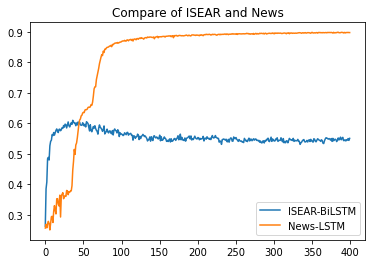

In [8]:
result = pd.read_csv('../results/isear_0_w2v_bi_fullresult/result.csv').head(400)
news_result = pd.read_csv('result/result.csv')

compare = pd.concat([result['accuracy'], news_result['accuracy']], axis=1)
compare.columns = ['ISEAR-BiLSTM', 'News-LSTM']
compare.plot(title='Compare of ISEAR and News')

      epoch  accuracy  train_loss
0         1  0.263296    1.928013
1         2  0.385424    1.782400
2         3  0.407748    1.702181
3         4  0.483913    1.609089
4         5  0.488510    1.586602
...     ...       ...         ...
1560   1561  0.546290    0.058807
1561   1562  0.545634    0.063839
1562   1563  0.546290    0.069805
1563   1564  0.546290    0.068121
1564   1565  0.546290    0.075836

[1565 rows x 3 columns]


<AxesSubplot:title={'center':'overfitting in ISEAR'}>

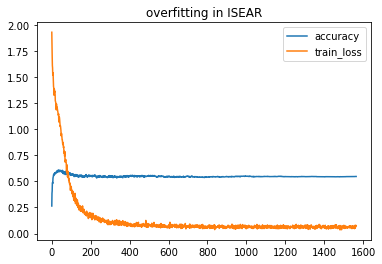

In [10]:
result = pd.read_csv('../results/isear_0_w2v_bi_fullresult/result.csv')
print(result)
pd.concat([result['accuracy'], result['train_loss']], axis=1).plot(title='overfitting in ISEAR')

## 2. SSL does not work well in emotion corpora

### a. Crawled unlabeled data low quality

In Proposal, SSL data needs to meet clustering assumptions, but crawler data may not be easy to satisfy

### b. Datasets and tasks are difficult

A simple uni-directional LSTM with no pre-trained words embedded in the reference can achieve 90% accuracy on the news dataset.

And my model may not able to exract real features about emotions.

## 3. How to deal with non emotional unlabeled data